In [ ]:
import os
os.chdir(notebook_path)
!pwd

/content/drive/MyDrive/Colab Notebooks


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

PROCESS 1

In [ ]:
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [ ]:
iris = load_iris()
X = iris.data

PROCESS 2

In [ ]:
k = 3

In [ ]:
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(X)
cluster_labels = kmeans.labels_
cluster_centers = kmeans.cluster_centers_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
print("Cluster labels: ", cluster_labels)
print("Cluster centers: \n", cluster_centers)

Cluster labels:  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 2 2 2 2 0 2 2 2 2
 2 2 0 0 2 2 2 2 0 2 0 2 0 2 2 0 0 2 2 2 2 2 0 2 2 2 2 0 2 2 2 0 2 2 2 0 2
 2 0]
Cluster centers: 
 [[5.9016129  2.7483871  4.39354839 1.43387097]
 [5.006      3.428      1.462      0.246     ]
 [6.85       3.07368421 5.74210526 2.07105263]]


In [ ]:
print("Within-cluster sum of squared distances: ", kmeans.inertia_)

Within-cluster sum of squared distances:  78.851441426146


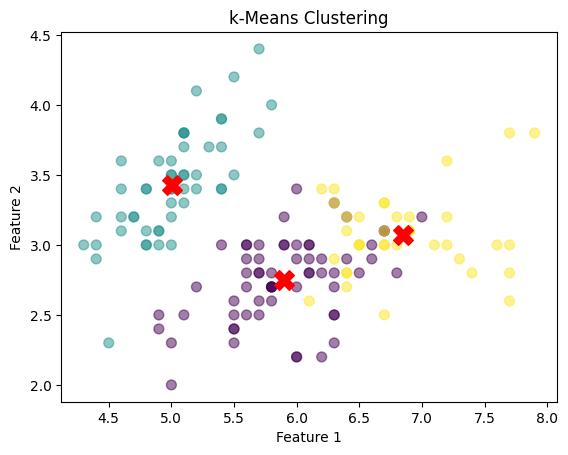

In [ ]:
plt.scatter(X[:, 0], X[:, 1], c=cluster_labels, cmap='viridis', s=50, alpha=0.5)
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='red', s=200, marker='X')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('k-Means Clustering')
plt.show()


PROCESS 3. k-Means Validation

In [ ]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

In [ ]:
silhouette_avg = silhouette_score(X, cluster_labels)

In [ ]:
davies_bouldin = davies_bouldin_score(X, cluster_labels)

In [ ]:
print("Silhouette Score:", silhouette_avg)
print("Davies-Bouldin Index:", davies_bouldin)

Silhouette Score: 0.5528190123564095
Davies-Bouldin Index: 0.6619715465007465


PROCESS 4

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
X_clustered = X

In [ ]:
pca = PCA()

In [ ]:
X_pca = pca.fit_transform(X_clustered)

In [ ]:
pca_df = pd.DataFrame(data = X_pca,
                      columns = ["principal component 1", "principal component 2", "principal component 3", "principal component 4"])
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))


Explained variation per principal component: [0.92461872 0.05306648 0.01710261 0.00521218]


In [ ]:
pca_df.tail()

,principal component 1,principal component 2,principal component 3,principal component 4
145,1.944110,0.187532,0.177825,-0.426196
146,1.527167,-0.375317,-0.121898,-0.254367
147,1.764346,0.078859,0.130482,-0.137001
148,1.900942,0.116628,0.723252,-0.044595
149,1.390189,-0.282661,0.362910,0.155039


PROCESS 5

In [ ]:
class XMeans:
    def __init__(self, k_init=2, **k_means_args):
        self.k_init = k_init
        self.k_means_args = k_means_args

    def fit(self, X):
        self.cluster_centers_ = np.array([np.mean(X, axis=0)])
        self.clusters_ = [range(len(X))]
        self.km_model = KMeans(n_clusters=self.k_init, **self.k_means_args)
        self.km_model.fit(X)
        self.labels_ = self.km_model.labels_
        self._recursively_split(X)

    def _recursively_split(self, X):
        for cluster_indices in self.clusters_:
            if len(cluster_indices) <= 1:
                continue

            X_cluster = X[cluster_indices]
            km_model = KMeans(n_clusters=2, **self.k_means_args)
            km_model.fit(X_cluster)
            labels = km_model.labels_
            centers = km_model.cluster_centers_

            bic = self._compute_bic(X_cluster, centers, labels)
            bic_split = self._compute_bic(X_cluster, X_cluster, labels)

            if bic_split - bic > np.log(len(cluster_indices)):
                self.cluster_centers_ = np.vstack([self.cluster_centers_, centers])
                indices1 = [cluster_indices[i] for i in range(len(cluster_indices)) if labels[i] == 0]
                indices2 = [cluster_indices[i] for i in range(len(cluster_indices)) if labels[i] == 1]
                self.clusters_.remove(cluster_indices)
                self.clusters_.append(indices1)
                self.clusters_.append(indices2)
            else:
                self.cluster_centers_ = np.vstack([self.cluster_centers_, centers])

    def _compute_bic(self, X, centers, labels):
        n_clusters = centers.shape[0]
        n_points = X.shape[0]
        n_features = X.shape[1]

        # compute the variance for all clusters beforehand
        variance = np.array([X[labels == i].var(axis=0) for i in range(n_clusters)])
        labels = self.km_model.labels_
        p = n_clusters * n_features + n_clusters - 1

        bic = (n_clusters * np.log(n_points) * p -
               2 * np.sum([np.sum(labels == i) * np.log(np.sum(labels == i))
                           for i in range(n_clusters)]) +
               np.sum([np.sum((X[labels == i] - centers[i]) ** 2) / X[labels == i].shape[0]
                       for i in range(n_clusters)]) + np.log(n_points) * p)

        return bic


In [ ]:
xmeans = XMeans()
xmeans.fit(X)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-71-c3992f5749ec>:44: RuntimeWarning: Degrees of freedom <= 0 for slice
  variance = np.array([X[labels == i].var(axis=0) for i in range(n_clusters)])
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
<ipython-input-71-c3992f5749ec>:49: RuntimeWarning:

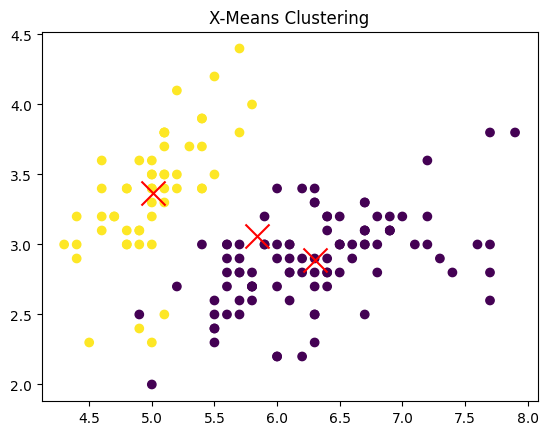

In [ ]:
plt.scatter(X[:, 0], X[:, 1], c=xmeans.labels_, cmap='viridis')
plt.scatter(xmeans.cluster_centers_[:, 0], xmeans.cluster_centers_[:, 1], s=300, c='red', marker='x')
plt.title('X-Means Clustering')
plt.show()